# Import

In [82]:
import json
import psycopg2
import time
import pandas as pd
from datetime import datetime
import numpy as np
import math
import pickle
import warnings
import os
import pandas.io.sql as sqlio
# from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to DataBase

In [83]:
# SoftTouch Lenses complete database
# conn = psycopg2.connect(
#     host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
#     port='5432',
#     user='softtouchlenses_4e0b7c925f8444429457581f35678aea',
#     password='softtouchlenses_4e0b7c925f8444429457581f35678aea_password',
#     database='softtouchlenses_4e0b7c925f8444429457581f35678aea_db'
# )

conn = psycopg2.connect(
    host = "shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com",
    port = '5432',
    user = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c",
    password = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password",
    database = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db"
)

# Fetch and Derive Required Data

C:\Users\CEPL\AppData\Local\Temp\ipykernel_2964\3800989066.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  e=pd.read_sql(q,conn)


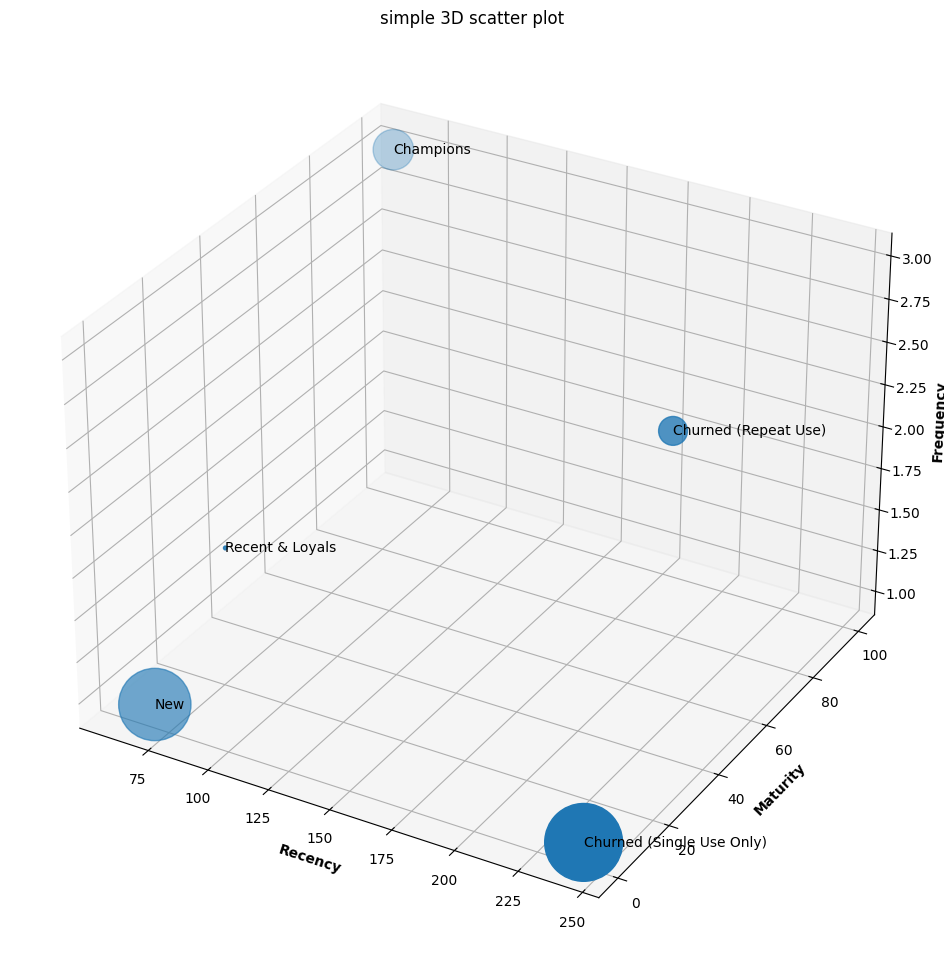

In [84]:
q=('''select created_at as order_date,
id as order_id,
total_price as order_amount,
customer_id as user_id
from orders
WHERE
cancelled_at is NULL;

''')


e=pd.read_sql(q,conn)
e = e[e['order_date'] >= '2023-01-01']
e = e[e['order_date'] <= '2023-12-31']
# e = e[e['order_date'] <= '2023-06-30']
e['order_date']=e['order_date'].dt.date
e['order_date']=pd.to_datetime(e['order_date'])
e['user_id']=e['user_id']
e['order_amount']=e['order_amount']



#Delta Columns
e['DeltaDaysinOrders']=(e.groupby('user_id').order_date.shift() - e.order_date).dt.days.abs()
e['DeltaOrderValues']=(e.groupby('user_id').order_amount.shift() - e.order_amount)

x1=e.groupby('user_id').agg(
        LastDate=pd.NamedAgg(column='order_date', aggfunc= 'max'),
        FirstDate=pd.NamedAgg(column='order_date', aggfunc='min'),
        Frequency=pd.NamedAgg(column='order_id', aggfunc='count'),
        AOV=pd.NamedAgg(column='order_amount', aggfunc='sum'),
        MeanDaysDelta=pd.NamedAgg(column='DeltaDaysinOrders', aggfunc='mean'),
        MeanOVDelta=pd.NamedAgg(column='DeltaOrderValues', aggfunc='mean'),
        SecondDate=pd.NamedAgg(column='order_date', aggfunc=lambda x: x.nsmallest(2).max()),
        TotalTransactions=pd.NamedAgg(column='order_id', aggfunc='nunique')
    ).reset_index()


globalmaxdate=e['order_date'].max()
x1['Recency']=globalmaxdate-x1['LastDate']
x1['Recency']=x1['Recency'].dt.days.abs()
x1['ActivatedQuater']=x1['FirstDate'].dt.to_period('Q')
x1['MaturityAge']=x1['LastDate']-x1['FirstDate']
x1['MaturityAge']=x1['MaturityAge'].dt.days.abs()
x1['MeanDaysDelta']=x1['MeanDaysDelta'].fillna(0)
x1['MeanOVDelta']=x1['MeanOVDelta'].fillna(0)
# x1['FrequencyperDeltaDays']=x1['Frequency']/x1['MeanDaysDelta']


r_labels, f_labels,AOV_labels, m_labels,DelAOV_labels = range(4, 0, -1), range(1,5), range(1,5),range(1,5),range(1,5)
x1['r_score'] = x1['Recency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = r_labels)).astype('int64')
x1['f2d_score'] = x1['Frequency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = f_labels)).astype('int64')
x1['AOV_score'] = x1['AOV'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = AOV_labels)).astype('int64')
x1['m_score'] = x1['MaturityAge'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = m_labels)).astype('int64')
x1['DelAOV'] = x1['MeanOVDelta'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = DelAOV_labels)).astype('int64')
x1['SumScore'] = x1['r_score'] + x1['f2d_score'] + x1['m_score'] + x1['AOV_score']+ x1['DelAOV']

def CohortLables_3(df):
    if ((df['Frequency']==1) & (df['r_score']>2)):
        return "New"
    elif ((df['Frequency'] == 1) & (df['r_score'] <= 2)):
        return 'Churned (Single Use Only)'
    elif ((df['Frequency'] > 1) & (df['m_score'] < 3) & (df['r_score'] >2)):
        return 'Recent & Loyals'
    elif ((df['Frequency'] > 1) & (df['m_score'] >=3) & (df['r_score'] > 2)):
        return 'Champions'
    else:
        return 'Churned (Repeat Use)'
        
# Create a new variable RFM_Level
x1['CohortLabel'] = x1.apply(CohortLables_3, axis=1)



segstats=x1.groupby(
   'CohortLabel'
).agg(
       Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),  
       Recency=pd.NamedAgg(column='Recency', aggfunc='mean'),
       Frequency=pd.NamedAgg(column='Frequency', aggfunc='mean'),
       AOV=pd.NamedAgg(column='AOV', aggfunc='mean'),
       MeanDaysDelta=pd.NamedAgg(column='MeanDaysDelta', aggfunc='mean'),
       MeanOVDelta=pd.NamedAgg(column='MeanOVDelta', aggfunc='mean'),
      # FrequencyperDeltaDays=pd.NamedAgg(column='FrequencyperDeltaDays', aggfunc='mean'),
    Maturity=pd.NamedAgg(column='MaturityAge', aggfunc='mean')
   
 ).reset_index()

segstats['OrderCountMix']=segstats['Frequency']/segstats['Frequency'].sum()
segstats['UsersMix']=segstats['Users']/segstats['Users'].sum()


#Visualization of cohorts with key parameters as axises
fig = plt.figure(figsize = (25, 12))
ax = plt.axes(projection ="3d")
size=segstats['Users']*.25
# Creating plot
ax.scatter3D(segstats['Recency'], segstats['Maturity'],segstats['Frequency'], s=size)
plt.title("simple 3D scatter plot")
ax.set_xlabel('Recency', fontweight ='bold')
ax.set_ylabel('Maturity', fontweight ='bold')
ax.set_zlabel('Frequency', fontweight ='bold')
for i in range(len(segstats)):
     ax.text(segstats['Recency'][i],
               segstats['Maturity'][i],
             segstats['Frequency'][i],
               segstats['CohortLabel'][i],
               horizontalalignment='left',
               rotation=25, wrap=True,
               verticalalignment='center',
               size='medium', color='black')
     
   
   
##traxn level insights Trxn Dist by Acquisition months
e2=e.merge(x1[['user_id','MeanDaysDelta','MeanOVDelta','LastDate','FirstDate']], left_on='user_id', right_on='user_id')
e2['AcqMonth']=e2['FirstDate'].dt.strftime('%Y-%m')
e2['OrderMonth']=e2['order_date'].dt.strftime('%Y-%m')

x2=e2.groupby(
   ['AcqMonth','OrderMonth']
).agg(
       Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),  
        ).unstack()

x2=x2.reset_index()

In [85]:
sum_row = segstats.sum(numeric_only=True)
segstats = pd.concat([segstats, sum_row.to_frame().T], ignore_index=True)
segstats.at[segstats.index[-1], 'CohortLabel'] = 'Overall'
segstats

,CohortLabel,Users,Recency,Frequency,AOV,MeanDaysDelta,MeanOVDelta,Maturity,OrderCountMix,UsersMix
0,Champions,3406.0,59.344979,2.985614,1887.699063,60.870377,19.068229,100.061069,0.315022,0.119195
1,Churned (Repeat Use),1731.0,216.285384,2.425188,1965.726620,45.441525,62.072592,60.015598,0.255890,0.060577
2,Churned (Single Use Only),12556.0,242.906260,1.000000,606.609752,0.000000,0.000000,0.000000,0.105513,0.439405
3,New,10852.0,69.386104,1.000000,350.416472,0.000000,0.000000,0.000000,0.105513,0.379773
4,Recent & Loyals,30.0,101.266667,2.066667,727.636667,0.000000,8.286667,0.000000,0.218061,0.001050
5,Overall,28575.0,689.189394,9.477468,5538.088574,106.311902,89.427488,160.076667,1.000000,1.000000


# Repurchase Chart

In [113]:
repurchase_table = e2.groupby([
   'AcqMonth', 'OrderMonth']
).agg(
       Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
 ).unstack()

repurchase_table.columns = repurchase_table.columns.droplevel(0)

repurchase_table = repurchase_table.fillna(0)
repurchase_table = repurchase_table.astype(int)

In [114]:
repurchase_table

OrderMonth,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
AcqMonth,,,,,,,,,,,,
2023-01,3227,199,181,213,162,170,177,81,128,137,78,71
2023-02,0,1859,80,143,94,101,89,59,67,84,62,45
2023-03,0,0,1449,114,109,80,78,39,53,54,40,24
2023-04,0,0,0,1538,159,114,111,58,72,80,47,38
2023-05,0,0,0,0,1601,101,90,56,61,71,62,25
2023-06,0,0,0,0,0,1302,78,60,74,54,64,30
2023-07,0,0,0,0,0,0,2662,135,97,105,68,42
2023-08,0,0,0,0,0,0,0,3282,150,116,86,60
2023-09,0,0,0,0,0,0,0,0,3532,226,114,84


In [115]:
def divide_non_zero(row):
    first_non_zero = None
    for i in range(len(row)):
        if row.iloc[i] != 0:
            if first_non_zero is None:
                first_non_zero = row.iloc[i]
            else:
                row.iloc[i] = row.iloc[i] / first_non_zero
    return row

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    repurchase_table_ratio = repurchase_table.apply(divide_non_zero, axis=1)
repurchase_table_ratio = repurchase_table_ratio.round(2)

In [116]:
for i in range(1, len(repurchase_table_ratio)):
    repurchase_table_ratio.iloc[i, :i] = "-"
for i in range(1, len(repurchase_table)):
    repurchase_table.iloc[i, :i] = "-"
# repurchase_table_ratio.iloc[i, i] =   # round(repurchase_table_ratio.iloc[i, i], -1)  # int(repurchase_table_ratio.iloc[i, i])   # int(str(repurchase_table_ratio.iloc[i, i])[:-2])

C:\Users\CEPL\AppData\Local\Temp\ipykernel_2964\2059624869.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  repurchase_table_ratio.iloc[i, :i] = "-"
C:\Users\CEPL\AppData\Local\Temp\ipykernel_2964\2059624869.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  repurchase_table.iloc[i, :i] = "-"


In [117]:
repurchase_table_ratio

OrderMonth,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
AcqMonth,,,,,,,,,,,,
2023-01,3227.0,0.06,0.06,0.07,0.05,0.05,0.05,0.03,0.04,0.04,0.02,0.02
2023-02,-,1859.0,0.04,0.08,0.05,0.05,0.05,0.03,0.04,0.05,0.03,0.02
2023-03,-,-,1449.0,0.08,0.08,0.06,0.05,0.03,0.04,0.04,0.03,0.02
2023-04,-,-,-,1538.0,0.1,0.07,0.07,0.04,0.05,0.05,0.03,0.02
2023-05,-,-,-,-,1601.0,0.06,0.06,0.03,0.04,0.04,0.04,0.02
2023-06,-,-,-,-,-,1302.0,0.06,0.05,0.06,0.04,0.05,0.02
2023-07,-,-,-,-,-,-,2662.0,0.05,0.04,0.04,0.03,0.02
2023-08,-,-,-,-,-,-,-,3282.0,0.05,0.04,0.03,0.02
2023-09,-,-,-,-,-,-,-,-,3532.0,0.06,0.03,0.02


In [118]:
repurchase_table_ratio_to_show = pd.DataFrame(index=repurchase_table_ratio.index)

def get_diagonal_elements(df, col_num):
    diagonal_elements = [df.iloc[i, col_num + i] for i in range(min(df.shape[0], df.shape[1] - col_num))]
    return diagonal_elements

diagonals = []
for i in range (0, len(repurchase_table_ratio)):
    x = get_diagonal_elements(repurchase_table_ratio, i)
    diagonals.append(x)

padded_diagonals = [l + [np.nan] * (len(repurchase_table_ratio) - len(l)) for l in diagonals]

for i in range (len(padded_diagonals)):
    repurchase_table_ratio_to_show[i] = padded_diagonals[i]
x = repurchase_table_ratio_to_show.columns.tolist()
x[0] = "Customer Count"
repurchase_table_ratio_to_show.columns = x
repurchase_table_ratio_to_show.columns.name = "Repurchase_Month_Index"
repurchase_table_ratio_to_show

Repurchase_Month_Index,Customer Count,1,2,3,4,5,6,7,8,9,10,11
AcqMonth,,,,,,,,,,,,
2023-01,3227.0,0.06,0.06,0.07,0.05,0.05,0.05,0.03,0.04,0.04,0.02,0.02
2023-02,1859.0,0.04,0.08,0.05,0.05,0.05,0.03,0.04,0.05,0.03,0.02,NaN
2023-03,1449.0,0.08,0.08,0.06,0.05,0.03,0.04,0.04,0.03,0.02,NaN,NaN
2023-04,1538.0,0.10,0.07,0.07,0.04,0.05,0.05,0.03,0.02,NaN,NaN,NaN
2023-05,1601.0,0.06,0.06,0.03,0.04,0.04,0.04,0.02,NaN,NaN,NaN,NaN
2023-06,1302.0,0.06,0.05,0.06,0.04,0.05,0.02,NaN,NaN,NaN,NaN,NaN
2023-07,2662.0,0.05,0.04,0.04,0.03,0.02,NaN,NaN,NaN,NaN,NaN,NaN
2023-08,3282.0,0.05,0.04,0.03,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09,3532.0,0.06,0.03,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
mean_lst = []
for i in range (1, 11):
    dummy = (repurchase_table_ratio_to_show.iloc[:-i, i]).mean()
    # print(repurchase_table_ratio_to_show.iloc[:-i, i])
    mean_lst.append(dummy)
mean_lst_diff = []
for i in range (1, len(mean_lst)):
    mean_lst_diff.append(((mean_lst[i] - mean_lst[i-1]) * 100) / mean_lst[i])
    
for i in range (len(mean_lst_diff)):
    if abs(mean_lst_diff[i]) < 11:
        monthdiff = f"{i+1}th Month, {round(mean_lst[i], 2)}%"
        mail_subject = f"Month on Month retention keeps dropping till {i+1}th Month where it starts to stablize on an average of {round(mean_lst[i], 2)}%"
        mail_body = f"""
        """
        break
    else:
        mail_subject = f"Month on Month retention keeps dropping till {i+1}th Month where it starts to stablize on an average of {round(mean_lst[i], 2)}%"
str

str

In [14]:
from statistics import mean

repurchase_table_ratio_to_show_dummy = repurchase_table_ratio_to_show.fillna(0)
maturity1 = repurchase_table_ratio_to_show_dummy.iloc[:, 1].values.tolist()
maturity2 = repurchase_table_ratio_to_show_dummy.iloc[:, 2].values.tolist()
maturity3 = repurchase_table_ratio_to_show_dummy.iloc[:, 3].values.tolist()
m1, m2, m3 = mean(maturity1), mean(maturity2), mean(maturity3)
week_less_avg = [repurchase_table_ratio_to_show_dummy.index.tolist()[i] for i in range (len(repurchase_table_ratio_to_show_dummy)) if repurchase_table_ratio_to_show_dummy.iloc[i, 1] < m1 and repurchase_table_ratio_to_show_dummy.iloc[i, 2] < m2 and repurchase_table_ratio_to_show_dummy.iloc[i, 3] < m3]
mail_value_1 = round(len(week_less_avg) * 100 / len(repurchase_table_ratio_to_show_dummy), 2)
if mail_value_1 < 35:
    mail_subject = f"~ {mail_value_1}% Months With Below Average 1st, 2nd and 3rd Month Repurchase Ratio"
    mail_body = f"""
Hi Paras,

Good Day!

SuperU bots have discovered insights on Repurchase Behavior.
It has detected that more than {mail_value_1}% of the monthly customer cohorts have below average repurchase ratio .

Which monthly cohorts are lagging more and which months are doing better, please have a deep dive about repurchase behavior here:

Repurchase Behavior (link)

Please feel free to reach Team Super U at +919329379799"""
else:
    m2 = repurchase_table_ratio_to_show_dummy.iloc[:, 1].values.tolist()
    mail_value_1 = min(m2)
    mail_value_2 = max(m2)
    m4 = repurchase_table_ratio_to_show_dummy.iloc[:, 3].values.tolist()
    mail_value_3 = min(m4)
    mail_value_4 = max(m4)
    mail_subject = f"Overall 3rd Month Repurchase Ratio Ranges From {mail_value_3}% to {mail_value_4}%"
    mail_body = f"""
Hi Paras,

Good Day!

SuperU bots have discovered insights on Repurchase Behavior.
It has detected that your 3rd month repurchase ratio ranges between {mail_value_3}% and {mail_value_4}%.

Which monthly cohorts are lagging more and which months are doing better, please have a deep dive about repurchase behavior here:

Repurchase Behavior (link)

Please feel free to reach Team Super U at +919329379799"""
print(mail_subject)
print(mail_body)

~ 33.33% Months With Below Average 1st, 2nd and 3rd Month Repurchase Ratio

Hi Paras,

Good Day!

SuperU bots have discovered insights on Repurchase Behavior.
It has detected that more than 33.33% of the monthly customer cohorts have below average repurchase ratio .

Which monthly cohorts are lagging more and which months are doing better, please have a deep dive about repurchase behavior here:

Repurchase Behavior (link)

Please feel free to reach Team Super U at +919329379799


In [15]:
# 1 - 3 months retention average, how many months below and above average
# 1st month last 3 avg vs overall 1st month avg
# 3rd month last 3 avg vs overall 3st month avg

In [94]:
repurchase_table_to_show = pd.DataFrame(index=repurchase_table.index)

def get_diagonal_elements(df, col_num):
    diagonal_elements = [df.iloc[i, col_num + i] for i in range(min(df.shape[0], df.shape[1] - col_num))]
    return diagonal_elements

diagonals = []
for i in range (0, len(repurchase_table)):
    x = get_diagonal_elements(repurchase_table, i)
    diagonals.append(x)

padded_diagonals = [l + [np.nan] * (len(repurchase_table)- len(l)) for l in diagonals]

for i in range (len(padded_diagonals)):
    repurchase_table_to_show[i] = padded_diagonals[i]
x = repurchase_table_to_show.columns.tolist()
x[0] = "Customer Count"
repurchase_table_to_show.columns = x
repurchase_table_to_show.columns.name = "Repurchase_Month_Index"
repurchase_table_to_show

Repurchase_Month_Index,Customer Count,1,2,3,4,5,6,7,8,9,10,11
AcqMonth,,,,,,,,,,,,
2023-01,3227,199.0,181.0,213.0,162.0,170.0,177.0,81.0,128.0,137.0,78.0,71.0
2023-02,1859,80.0,143.0,94.0,101.0,89.0,59.0,67.0,84.0,62.0,45.0,NaN
2023-03,1449,114.0,109.0,80.0,78.0,39.0,53.0,54.0,40.0,24.0,NaN,NaN
2023-04,1538,159.0,114.0,111.0,58.0,72.0,80.0,47.0,38.0,NaN,NaN,NaN
2023-05,1601,101.0,90.0,56.0,61.0,71.0,62.0,25.0,NaN,NaN,NaN,NaN
2023-06,1302,78.0,60.0,74.0,54.0,64.0,30.0,NaN,NaN,NaN,NaN,NaN
2023-07,2662,135.0,97.0,105.0,68.0,42.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-08,3282,150.0,116.0,86.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09,3532,226.0,114.0,84.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
def get_diagonal_elements(df, col_num):
    diagonal_elements = [df.iloc[i, col_num + i] for i in range(min(df.shape[0], df.shape[1] - col_num))]
    return diagonal_elements

diagonals_percentage, diagonals_difference = [], []
for i in range (1, len(repurchase_table_ratio)-1):
    x = get_diagonal_elements(repurchase_table_ratio, i)
    # print(x)
    z = [(x[i+1] - x[i])*100/x[i] for i in range (len(x)-1)]
    zz = [(x[i+1] - x[i]) for i in range (len(x)-1)]
    diagonals_percentage.append(z)
    diagonals_difference.append(zz)

In [18]:
x = len(diagonals_percentage[0])
padded_diagonals_percentage = [[np.nan] + l + [np.nan] * (x - len(l)+1) for l in diagonals_percentage]

Repurchase_Percentage = pd.DataFrame(index = repurchase_table_ratio.index)

for i in range (len(padded_diagonals_percentage)):
    Repurchase_Percentage.insert(i, f'{i}', padded_diagonals_percentage[i])

Repurchase_Percentage.columns.name = "Month_Index"
Repurchase_Percentage

Month_Index,0,1,2,3,4,5,6,7,8,9
AcqMonth,,,,,,,,,,
2023-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02,-30.307942,37.076649,-23.333333,8.167331,-9.108159,-42.153285,43.426295,13.853904,-21.411765,-40.082645
2023-03,83.023256,-2.210663,9.090909,-0.920810,-43.841336,15.457413,3.611111,-38.938053,-60.778443,NaN
2023-04,31.385006,-1.462766,30.797101,-29.925651,73.977695,42.076503,-17.962466,-43.478261,NaN,NaN
2023-05,-38.974855,-24.156545,-51.523546,1.061008,-5.341880,-25.576923,-63.398693,NaN,NaN,NaN
2023-06,-5.071315,-17.971530,62.285714,8.923885,11.060948,-54.263566,NaN,NaN,NaN,NaN
2023-07,-15.358932,-21.041215,-30.633803,-38.554217,-76.422764,NaN,NaN,NaN,NaN,NaN
2023-08,-9.861933,-3.021978,-33.502538,-58.039216,NaN,NaN,NaN,NaN,NaN,NaN
2023-09,40.043764,-8.498584,-33.969466,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
x = len(diagonals_difference[0])
padded_diagonals_difference = [[np.nan] + l + [np.nan] * (x - len(l)+1) for l in diagonals_difference]

Repurchase_Difference = pd.DataFrame(index = repurchase_table_ratio.index)

for i in range (len(padded_diagonals_difference)):
    Repurchase_Difference.insert(i, f'{i}', padded_diagonals_difference[i])

Repurchase_Difference.columns.name = "Month_Index"
Repurchase_Difference

Month_Index,0,1,2,3,4,5,6,7,8,9
AcqMonth,,,,,,,,,,
2023-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02,-1.87,2.08,-1.54,0.41,-0.48,-2.31,1.09,0.55,-0.91,-0.97
2023-03,3.57,-0.17,0.46,-0.05,-2.10,0.49,0.13,-1.76,-2.03,NaN
2023-04,2.47,-0.11,1.70,-1.61,1.99,1.54,-0.67,-1.20,NaN,NaN
2023-05,-4.03,-1.79,-3.72,0.04,-0.25,-1.33,-1.94,NaN,NaN,NaN
2023-06,-0.32,-1.01,2.18,0.34,0.49,-2.10,NaN,NaN,NaN,NaN
2023-07,-0.92,-0.97,-1.74,-1.60,-3.76,NaN,NaN,NaN,NaN,NaN
2023-08,-0.50,-0.11,-1.32,-1.48,NaN,NaN,NaN,NaN,NaN,NaN
2023-09,1.83,-0.30,-0.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
major_months = {}
for i in range (3):
    Repurchase_Difference_sorted = Repurchase_Difference.iloc[1:-1, :]
    Repurchase_Difference_sorted = Repurchase_Difference_sorted.sort_values(by=Repurchase_Difference.columns.tolist()[i], ascending = False)
    major_months[f"Top 2 for Month Index {i+1}"] = Repurchase_Difference_sorted.index.tolist()[:2]
    major_months[f"Bottom 2 for Month Index {i+1}"] = Repurchase_Difference_sorted.index.tolist()[-2:]

In [21]:
for i in major_months:
    print(i)
    print(Repurchase_Difference.loc[(major_months[i])])

Top 2 for Month Index 1
Month_Index     0     1     2     3     4     5     6     7     8   9
AcqMonth                                                             
2023-03      3.57 -0.17  0.46 -0.05 -2.10  0.49  0.13 -1.76 -2.03 NaN
2023-04      2.47 -0.11  1.70 -1.61  1.99  1.54 -0.67 -1.20   NaN NaN
Bottom 2 for Month Index 1
Month_Index     0     1     2     3     4     5     6     7     8     9
AcqMonth                                                               
2023-02     -1.87  2.08 -1.54  0.41 -0.48 -2.31  1.09  0.55 -0.91 -0.97
2023-05     -4.03 -1.79 -3.72  0.04 -0.25 -1.33 -1.94   NaN   NaN   NaN
Top 2 for Month Index 2
Month_Index     0     1     2     3     4     5     6     7     8     9
AcqMonth                                                               
2023-02     -1.87  2.08 -1.54  0.41 -0.48 -2.31  1.09  0.55 -0.91 -0.97
2023-04      2.47 -0.11  1.70 -1.61  1.99  1.54 -0.67 -1.20   NaN   NaN
Bottom 2 for Month Index 2
Month_Index     0     1     2     3     4 

In [22]:
MoM_Maturing = pd.DataFrame(index = repurchase_table_ratio.index, columns = repurchase_table_ratio.columns)

x = get_diagonal_elements(repurchase_table_ratio, 0)
diagonals_percentage_to_table = diagonals_percentage.copy()
diagonals_percentage_to_table.insert(0, x)

def assign_diagonal_elements(df, diagonal_elements):
    for i in range (len(diagonal_elements)):
        for j in range (len(diagonal_elements[i])):
            # print(i, j)
            if i == 0:
                df.iloc[j, j] = diagonal_elements[i][j]
            else:
                try:
                    df.iloc[j+1, i+j+1] = diagonal_elements[i][j]
                except:
                    pass
    return df

MoM_Maturing = assign_diagonal_elements(MoM_Maturing, diagonals_percentage_to_table)

MoM_Maturing

OrderMonth,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
AcqMonth,,,,,,,,,,,,
2023-01,3227.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02,NaN,1859.0,-30.307942,37.076649,-23.333333,8.167331,-9.108159,-42.153285,43.426295,13.853904,-21.411765,-40.082645
2023-03,NaN,NaN,1449.0,83.023256,-2.210663,9.090909,-0.92081,-43.841336,15.457413,3.611111,-38.938053,-60.778443
2023-04,NaN,NaN,NaN,1538.0,31.385006,-1.462766,30.797101,-29.925651,73.977695,42.076503,-17.962466,-43.478261
2023-05,NaN,NaN,NaN,NaN,1601.0,-38.974855,-24.156545,-51.523546,1.061008,-5.34188,-25.576923,-63.398693
2023-06,NaN,NaN,NaN,NaN,NaN,1302.0,-5.071315,-17.97153,62.285714,8.923885,11.060948,-54.263566
2023-07,NaN,NaN,NaN,NaN,NaN,NaN,2662.0,-15.358932,-21.041215,-30.633803,-38.554217,-76.422764
2023-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3282.0,-9.861933,-3.021978,-33.502538,-58.039216
2023-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3532.0,40.043764,-8.498584,-33.969466


In [23]:
val = [i for s in diagonals_percentage for i in s]
len(val)

55

In [24]:
def create_buckets(percentage_values):
    sorted_values = sorted(percentage_values)
    n = len(sorted_values)
    bucket_boundaries = [
        sorted_values[int(n * i / 4)]
        for i in range(1, 4)
    ]

    # Create the buckets
    # buckets = {
    #     'Bucket 1': [value for value in percentage_values if value <= bucket_boundaries[0]],
    #     'Bucket 2': [value for value in percentage_values if bucket_boundaries[0] < value <= bucket_boundaries[1]],
    #     'Bucket 3': [value for value in percentage_values if bucket_boundaries[1] < value <= bucket_boundaries[2]],
    #     'Bucket 4': [value for value in percentage_values if value > bucket_boundaries[2]]
    # }

    return bucket_boundaries

buckets = create_buckets(val)

In [25]:
MoM_Maturing_Tags = MoM_Maturing.copy()
for i in range (len(MoM_Maturing_Tags)):
    for j in range (len(MoM_Maturing_Tags)):
        if i != j:
            if MoM_Maturing_Tags.iloc[i, j] <= buckets[0]:
                MoM_Maturing_Tags.iloc[i, j] = "Poor"
            elif MoM_Maturing_Tags.iloc[i, j] > buckets[0] and MoM_Maturing_Tags.iloc[i, j] <= buckets[1]:
                MoM_Maturing_Tags.iloc[i, j] = "Below Average"
            elif MoM_Maturing_Tags.iloc[i, j] > buckets[1] and MoM_Maturing_Tags.iloc[i, j] <= buckets[2]:
                MoM_Maturing_Tags.iloc[i, j] = "Above Average"
            elif MoM_Maturing_Tags.iloc[i, j] > buckets[2]:
               MoM_Maturing_Tags.iloc[i, j] = "Good"
            else:
                MoM_Maturing_Tags.iloc[i, j] = "No Data"

MoM_Maturing_Tags

OrderMonth,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
AcqMonth,,,,,,,,,,,,
2023-01,3227.0,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data
2023-02,No Data,1859.0,Below Average,Good,Below Average,Above Average,Above Average,Poor,Good,Good,Below Average,Poor
2023-03,No Data,No Data,1449.0,Good,Above Average,Good,Above Average,Poor,Good,Above Average,Poor,Poor
2023-04,No Data,No Data,No Data,1538.0,Good,Above Average,Good,Below Average,Good,Good,Below Average,Poor
2023-05,No Data,No Data,No Data,No Data,1601.0,Poor,Below Average,Poor,Above Average,Above Average,Below Average,Poor
2023-06,No Data,No Data,No Data,No Data,No Data,1302.0,Above Average,Below Average,Good,Above Average,Good,Poor
2023-07,No Data,No Data,No Data,No Data,No Data,No Data,2662.0,Below Average,Below Average,Below Average,Poor,Poor
2023-08,No Data,No Data,No Data,No Data,No Data,No Data,No Data,3282.0,Above Average,Above Average,Below Average,Poor
2023-09,No Data,No Data,No Data,No Data,No Data,No Data,No Data,No Data,3532.0,Good,Above Average,Below Average


In [26]:
buckets

[-38.55421686746989, -15.358931552587645, 8.923884514435702]

In [35]:
idx1 = repurchase_table_to_show.index.get_loc("2023-01")
idx2 = repurchase_table_to_show.index.get_loc("2023-07")
# idx3 = repurchase_table_to_show.columns.get_loc("2023-01")
# idx4 = repurchase_table_to_show.columns.get_loc("2023-07")
row_month = repurchase_table_to_show[idx1:idx2]
# nan_index = row_month.isna().idxmax(axis=1)[0]
# row_month = row_month.iloc[:, :nan_index]
# row_month.columns = pd.to_datetime(row_month.columns).strftime('%Y-%b')
row_month.index = pd.to_datetime(row_month.index).strftime('%Y-%b')
x = row_month.columns.tolist()
y = x[0:1] + [f"Month {x[i]}" for i in range (1, len(x))]
row_month.columns, row_month.columns.name, row_month.index.name = y, "Repurchase_Month_Index", "AcquiredMonth"
row_month

Repurchase_Month_Index,Customer Count,Month 1,Month 2,Month 3,Month 4,Month 5,Month 6,Month 7,Month 8,Month 9,Month 10,Month 11
AcquiredMonth,,,,,,,,,,,,
2023-Jan,3227,199.0,181.0,213.0,162.0,170.0,177.0,81.0,128.0,137.0,78.0,46.0
2023-Feb,1859,80.0,143.0,94.0,101.0,89.0,59.0,67.0,84.0,62.0,27.0,NaN
2023-Mar,1449,114.0,109.0,80.0,78.0,39.0,53.0,54.0,40.0,19.0,NaN,NaN
2023-Apr,1538,159.0,114.0,111.0,58.0,72.0,80.0,47.0,24.0,NaN,NaN,NaN
2023-May,1601,101.0,90.0,56.0,61.0,71.0,62.0,18.0,NaN,NaN,NaN,NaN
2023-Jun,1302,78.0,60.0,74.0,54.0,64.0,23.0,NaN,NaN,NaN,NaN,NaN


In [34]:
row_month.index.name

'AcqMonth'

In [28]:
# # (repurchase_table_ratio.tail(12)).iloc[:, -12:]
# idx1 = repurchase_table_ratio.index.get_loc("2023-01")
# idx2 = repurchase_table_ratio.index.get_loc("2023-07")
# idx3 = repurchase_table_ratio.columns.get_loc("2023-01")
# idx4 = repurchase_table.columns.get_loc("2023-07")
# row_month_ratio = repurchase_table_ratio[idx1:idx2]
# row_month_ratio = row_month_ratio.iloc[:, idx3:idx4]
# row_month_ratio.columns = pd.to_datetime(row_month_ratio.columns).strftime('%Y-%b')
# row_month_ratio.index = pd.to_datetime(row_month_ratio.index).strftime('%Y-%b')
# row_month_ratio

In [29]:
idx1 = repurchase_table_ratio_to_show.index.get_loc("2023-01")
idx2 = repurchase_table_ratio_to_show.index.get_loc("2023-07")
# idx3 = repurchase_table_to_show.columns.get_loc("2023-01")
# idx4 = repurchase_table_to_show.columns.get_loc("2023-07")
row_month = repurchase_table_ratio_to_show[idx1:idx2]
# nan_index = row_month.isna().idxmax(axis=1)[0]
# row_month = row_month.iloc[:, :nan_index]
# row_month.columns = pd.to_datetime(row_month.columns).strftime('%Y-%b')
row_month.index = pd.to_datetime(row_month.index).strftime('%Y-%b')
row_month

Repurchase_Month_Index,Customer Count,1,2,3,4,5,6,7,8,9,10,11
AcqMonth,,,,,,,,,,,,
2023-Jan,3227.0,6.17,5.61,6.60,5.02,5.27,5.48,2.51,3.97,4.25,2.42,1.43
2023-Feb,1859.0,4.30,7.69,5.06,5.43,4.79,3.17,3.60,4.52,3.34,1.45,NaN
2023-Mar,1449.0,7.87,7.52,5.52,5.38,2.69,3.66,3.73,2.76,1.31,NaN,NaN
2023-Apr,1538.0,10.34,7.41,7.22,3.77,4.68,5.20,3.06,1.56,NaN,NaN,NaN
2023-May,1601.0,6.31,5.62,3.50,3.81,4.43,3.87,1.12,NaN,NaN,NaN,NaN
2023-Jun,1302.0,5.99,4.61,5.68,4.15,4.92,1.77,NaN,NaN,NaN,NaN,NaN


In [30]:
# plt.figure(figsize=(10, 6))
# row_month_ratio = row_month_ratio.fillna(0)
# sns.heatmap(row_month_ratio, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5, cbar=True, square=True)

# # x_labels = range(0, 12)
# # x_positions = range(0, 12)
# # plt.xticks(x_positions, x_labels)
# # plt.xticks(rotation=0)
# plt.title('Repurchase Behavior')
# plt.xlabel('Repurchase month index')
# plt.ylabel('Cohort Start Month')
# plt.show()

In [31]:
# Alert
x = (repurchase_table_ratio.tail(12)).iloc[:, -12:]
diagonal_values = [x.iloc[i, i + 3] for i in range(min(len(x), 9))][-6:]
avg = sum(diagonal_values) / len(diagonal_values)
print("The third month maturity for the last 6 months is ", avg)

The third month maturity for the last 6 months is  4.115


In [32]:
# plt.figure(figsize=(10, 6))
# repurchase_table = repurchase_table.fillna(0)
# sns.heatmap((repurchase_table.tail(12)).iloc[:, -12:], annot=True, fmt='d', cmap='coolwarm', linewidths=.5, cbar=True, square=True)

# x_labels = range(0, 12)
# x_positions = range(0, 12)
# plt.xticks(x_positions, x_labels)
# plt.xticks(rotation=0)
# plt.title('Repurchase Behavior')
# plt.xlabel('Repurchase month index')
# plt.ylabel('Cohort Start Month')
# plt.show()

In [33]:
# plt.figure(figsize=(12, 10))
# repurchase_table = repurchase_table.fillna(0)
# sns.heatmap((repurchase_table_ratio.tail(12)).iloc[:, -12:], annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5, cbar=True, square=True)

# x_labels = range(0, 12)
# x_positions = range(0, 12)
# plt.xticks(x_positions, x_labels)
# plt.xticks(rotation=0)
# plt.yticks(rotation=0)
# plt.title('Repurchase Behavior')
# plt.xlabel('Repurchase month index')
# plt.ylabel('Cohort Start Month')
# plt.show()

# Number of Days Between Transactions

In [96]:
x1

,user_id,LastDate,FirstDate,Frequency,AOV,MeanDaysDelta,MeanOVDelta,SecondDate,TotalTransactions,Recency,ActivatedQuater,MaturityAge,r_score,f2d_score,AOV_score,m_score,DelAOV,SumScore,CohortLabel
0,2.912877e+12,2023-12-01,2023-01-24,3,1058.0,155.500000,-108.0,2023-04-02,3,29,2023Q1,311,4,4,4,4,1,17,Champions
1,3.555623e+12,2023-01-11,2023-01-11,1,840.0,0.000000,0.0,2023-01-11,1,353,2023Q1,0,1,1,4,1,1,8,Churned (Single Use Only)
2,3.556805e+12,2023-10-18,2023-09-06,3,1798.5,21.000000,10.0,2023-09-06,3,73,2023Q3,42,3,4,4,4,4,19,Champions
3,3.563085e+12,2023-01-10,2023-01-10,1,992.0,0.000000,0.0,2023-01-10,1,354,2023Q1,0,1,1,4,1,1,8,Churned (Single Use Only)
4,3.563224e+12,2023-10-17,2023-01-21,4,2850.0,89.666667,-155.0,2023-05-13,4,74,2023Q1,269,3,4,4,4,1,16,Champions
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28570,6.977640e+12,2023-12-30,2023-12-30,1,199.0,0.000000,0.0,2023-12-30,1,0,2023Q4,0,4,4,1,4,4,17,New
28571,6.977750e+12,2023-12-30,2023-12-30,1,299.0,0.000000,0.0,2023-12-30,1,0,2023Q4,0,4,4,2,4,4,18,New
28572,6.977763e+12,2023-12-30,2023-12-30,1,299.0,0.000000,0.0,2023-12-30,1,0,2023Q4,0,4,4,2,4,4,18,New
28573,6.977769e+12,2023-12-30,2023-12-30,1,199.0,0.000000,0.0,2023-12-30,1,0,2023Q4,0,4,4,1,4,4,17,New


In [97]:
# Date Filter 
# e2=e2[e2['OrderDate']>='2022-01-01']
# e2=e2[e2['OrderDate']<='2022-12-31']
txn_delta_day_count = x1[x1["Frequency"] > 1]

In [98]:
txn_delta_day_count

,user_id,LastDate,FirstDate,Frequency,AOV,MeanDaysDelta,MeanOVDelta,SecondDate,TotalTransactions,Recency,ActivatedQuater,MaturityAge,r_score,f2d_score,AOV_score,m_score,DelAOV,SumScore,CohortLabel
0,2.912877e+12,2023-12-01,2023-01-24,3,1058.0,155.500000,-108.0,2023-04-02,3,29,2023Q1,311,4,4,4,4,1,17,Champions
2,3.556805e+12,2023-10-18,2023-09-06,3,1798.5,21.000000,10.0,2023-09-06,3,73,2023Q3,42,3,4,4,4,4,19,Champions
4,3.563224e+12,2023-10-17,2023-01-21,4,2850.0,89.666667,-155.0,2023-05-13,4,74,2023Q1,269,3,4,4,4,1,16,Champions
6,3.568027e+12,2023-01-19,2023-01-06,2,960.0,13.000000,300.0,2023-01-19,2,345,2023Q1,13,1,4,4,4,4,17,Churned (Repeat Use)
9,3.568041e+12,2023-06-06,2023-05-05,2,1148.3,32.000000,449.7,2023-06-06,2,207,2023Q2,32,2,4,4,4,4,18,Churned (Repeat Use)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28464,6.972852e+12,2023-12-29,2023-12-27,2,598.0,2.000000,0.0,2023-12-29,2,1,2023Q4,2,4,4,3,4,4,19,Champions
28469,6.972867e+12,2023-12-30,2023-12-27,2,647.0,3.000000,199.0,2023-12-30,2,0,2023Q4,3,4,4,3,4,4,19,Champions
28489,6.973659e+12,2023-12-28,2023-12-28,3,972.0,0.000000,0.0,2023-12-28,3,2,2023Q4,0,4,4,4,4,4,20,Champions
28517,6.974046e+12,2023-12-28,2023-12-28,2,648.0,0.000000,0.0,2023-12-28,2,2,2023Q4,0,4,4,3,4,4,19,Champions


In [99]:
data = txn_delta_day_count["MeanDaysDelta"]
counts, bin_edges = np.histogram(data, bins=100)
histogram_table = pd.DataFrame({'Number of Days Between Successive Purchases': bin_edges[:-1], 'Customer Counts': counts})
histogram_table

,Number of Days Between Successive Purchases,Customer Counts
0,0.00,730
1,3.61,295
2,7.22,255
3,10.83,276
4,14.44,218
...,...,...
95,342.95,1
96,346.56,1
97,350.17,0
98,353.78,0


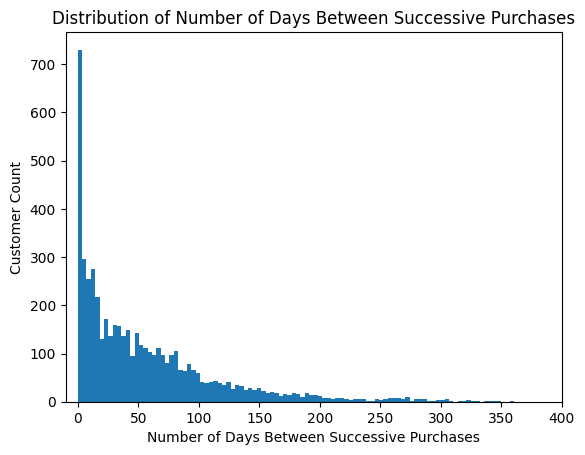

In [100]:
plt.hist(txn_delta_day_count["MeanDaysDelta"], bins = 100)
plt.title('Distribution of Number of Days Between Successive Purchases')
plt.ylabel('Customer Count')
plt.xlabel('Number of Days Between Successive Purchases')
plt.xlim(-10, 400)
plt.show()

C:\Users\CEPL\AppData\Local\Temp\ipykernel_2964\435068981.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(txn_delta_day_count["MeanDaysDelta"])


<Axes: xlabel='MeanDaysDelta', ylabel='Density'>

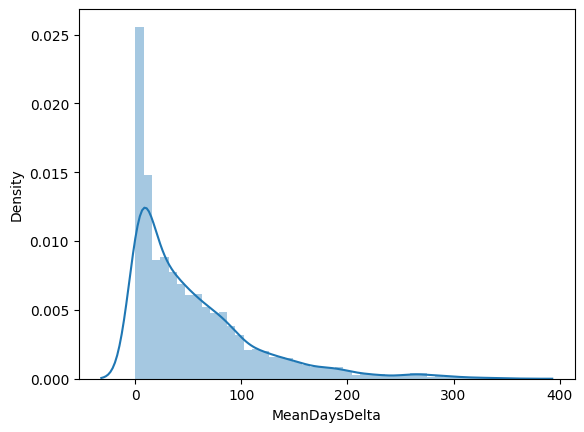

In [101]:
sns.distplot(txn_delta_day_count["MeanDaysDelta"])

In [102]:
# txn_delta_day_count['Decile'] = txn_delta_day_count['DeltaDaysinOrders'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [1, 2, 3, 4]))
# txn_delta_day_count['Decile'] = pd.qcut(txn_delta_day_count['DeltaDaysinOrders'].rank(method='first'), q=[0, 0.25, 0.5, 0.75, 1.0], labels=False)

In [103]:
# bins = [0, 15, 50, 100, 500, 1000, float('inf')]

# # Create labels for the bins
# labels = ['Less than 15', '15-50', '50-100', '100-500', '500-1000', 'Greater than 1000']

# # Use pd.cut to bin the 'DeltaDaysinOrders' column
# txn_delta_day_count['DeltaDaysCategory'] = pd.cut(txn_delta_day_count['DeltaDaysinOrders'], bins=bins, labels=labels)

# # Count the number of users in each bin
# user_counts = txn_delta_day_count['DeltaDaysCategory'].value_counts().reindex(labels, fill_value=0)

# # Print the user counts
# print(user_counts)

In [104]:
# # Find the minimum and maximum values of 'DeltaDaysinOrders'
# min_value = txn_delta_day_count['MeanDaysDelta'].min()
# max_value = txn_delta_day_count['MeanDaysDelta'].max()

# # Create 5 equally spaced bins with integral values
# bins = pd.cut(txn_delta_day_count['MeanDaysDelta'], bins=4, precision=0)

# # Get the bin labels
# labels = bins.value_counts().sort_index().index.tolist()

# # Count the number of users in each bin
# user_counts = bins.value_counts().reindex(labels, fill_value=0)

# # Print the user counts
# print(user_counts)

In [105]:
# min_value = txn_delta_day_count['MeanDaysDelta'].min()
# max_value = txn_delta_day_count['MeanDaysDelta'].max()
# bins = pd.cut(txn_delta_day_count['MeanDaysDelta'], bins=4, precision=0)
# labels = bins.value_counts().sort_index().index.tolist()
# user_counts = bins.value_counts().reindex(labels, fill_value=0)

# bin_df = pd.DataFrame({'Bin Range': labels, 'User Count': user_counts})
# bin_df.index.name = 'Bin'
# # print(bin_df)

# max_range = bin_df[bin_df['User Count'] == bin_df['User Count'].max()]['Bin Range'].values[0]
# inner_bins = pd.cut(txn_delta_day_count[txn_delta_day_count['MeanDaysDelta'].between(max_range.left, max_range.right, inclusive='both')]['MeanDaysDelta'], bins=10, precision=0, include_lowest=True)
# inner_labels = inner_bins.value_counts().sort_index().index.tolist()

# inner_user_counts = inner_bins.value_counts().reindex(inner_labels, fill_value=0)
# inner_bin_df = pd.DataFrame({'Inner Bin Range': inner_labels, 'User Count': inner_user_counts})
# inner_bin_df.index.name = 'Inner Bin'
# inner_bin_df.drop(columns = ["Inner Bin Range"], inplace = True)
# inner_bin_df

In [106]:
# min_value = txn_delta_day_count['MeanDaysDelta'].min()
# max_value = txn_delta_day_count['MeanDaysDelta'].max()

bins = pd.cut(txn_delta_day_count['MeanDaysDelta'], bins=4, precision=0)
labels = bins.value_counts().sort_index().index.tolist()
user_counts = bins.value_counts().reindex(labels, fill_value=0)

bin_df = pd.DataFrame({'Days Gap Between Transactions (Lower Limit)': [label.left for label in labels],
                       'Days Gap Between Transactions (Upper Limit)': [label.right for label in labels],
                       'Returned Customer Count': user_counts})
max_range = bin_df[bin_df['Returned Customer Count'] == bin_df['Returned Customer Count'].max()]
max_range
inner_bins = pd.cut(txn_delta_day_count[txn_delta_day_count['MeanDaysDelta'].between(max_range.iloc[0]['Days Gap Between Transactions (Lower Limit)'], max_range.iloc[0]['Days Gap Between Transactions (Upper Limit)'], inclusive='both')]['MeanDaysDelta'], bins=10, precision=0, include_lowest=False)
inner_labels = inner_bins.value_counts().sort_index().index.tolist()
inner_user_counts = inner_bins.value_counts().reindex(inner_labels, fill_value=0)

inner_bin_df = pd.DataFrame({'Days Gap Between Transactions (Lower Limit)': [label.left for label in inner_labels],
                            'Days Gap Between Transactions (Upper Limit)': [label.right for label in inner_labels],
                            'Returned Customer Count': inner_user_counts})

bin_df = bin_df[bin_df['Returned Customer Count'] != bin_df['Returned Customer Count'].max()]
bin_df = pd.concat([bin_df, inner_bin_df], ignore_index=True)
bin_df = bin_df.sort_values(by='Days Gap Between Transactions (Lower Limit)')
bin_df["No of Days Gap Between Transactions"] = bin_df[["Days Gap Between Transactions (Lower Limit)", "Days Gap Between Transactions (Upper Limit)"]].astype("str").apply("-".join, axis=1)
bin_df = bin_df[["No of Days Gap Between Transactions", "Returned Customer Count"]]
bin_df.T

,3,4,5,6,7,8,9,10,11,12,0,1,2
No of Days Gap Between Transactions,-0.1-9.0,9.0-18.0,18.0-27.0,27.0-36.0,36.0-45.0,45.0-54.0,54.0-63.0,63.0-72.0,72.0-81.0,81.0-90.0,90.0-180.0,180.0-271.0,271.0-361.0
Returned Customer Count,1190,584,392,365,342,299,278,242,226,184,818,190,57


In [107]:
dummy = str(bin_df.iloc[0, 0]).split("-")
if len(dummy) > 2:
    bin_df.iloc[0, 0] = f"0.0-{dummy[2]}"

for i in range(len(bin_df)):
    x = str(bin_df.iloc[i, 0])
    a = (x.split("-")[0])[:-2]
    b = (x.split("-")[1])[:-2]
    x = a + " - " + b + " Days"
    bin_df.iloc[i, 0] = x
bin_df.set_index("No of Days Gap Between Transactions", inplace = True)
bin_df.T

No of Days Gap Between Transactions,0 - 9 Days,9 - 18 Days,18 - 27 Days,27 - 36 Days,36 - 45 Days,45 - 54 Days,54 - 63 Days,63 - 72 Days,72 - 81 Days,81 - 90 Days,90 - 180 Days,180 - 271 Days,271 - 361 Days
Returned Customer Count,1190,584,392,365,342,299,278,242,226,184,818,190,57


In [108]:
bin_df["Returned Customer Count"].sum()

5167

In [109]:
bin_df["Returned Customer Count"].sum() + len(x1[x1["Frequency"]== 1])    #28447    15

28575

In [48]:
mail_value_1 = int(bin_df.T.columns.tolist()[2].split(" ")[2])
mail_value_2 = sum(bin_df.T.values.tolist()[0][:3]) * 100 / sum(bin_df.T.values.tolist()[0][:])

if mail_value_1/100 >= 1:
    mail_value_1 = round(mail_value_1, -2)
else:
    mail_value_1 = round(mail_value_1, -1)

mail_value_2 = round(mail_value_2, 2)

mail_subject = f"~ {100 - int(mail_value_2)}% of Customers Have Not Made a Purchase Within {mail_value_1} Days Following Their Last Transaction"

mail_body = f"""
Hi Paras

Good Day!
We have observed significant insights in our customers repeat transactions through our bots

The bots have found out that, nearly {100 - int(mail_value_2)}% of your customers, do not make a repeat purchase within {mail_value_1} days of their last transaction. 
What percentage of customers return early for repeat transaction. Please have a deep dive about repeat repurchase behavior here:

Numbers of days between orders (link)

Please feel free to reach Team Super U at +919329379799.
"""

print(mail_subject)
print(mail_body)

~ 60% of Customers Have Not Made a Purchase Within 30 Days Following Their Last Transaction

Hi Paras

Good Day!
We have observed significant insights in our customers repeat transactions through our bots

The bots have found out that, nearly 60% of your customers, do not make a repeat purchase within 30 days of their last transaction. 
What percentage of customers return early for repeat transaction. Please have a deep dive about repeat repurchase behavior here:

Numbers of days between orders (link)

Please feel free to reach Team Super U at +919329379799.



In [49]:
# sum(bin_df.T.values.tolist()[0][:3])
sum(bin_df.T.values.tolist()[0][:])

4997

# Retention

In [50]:
e

,order_date,order_id,order_amount,user_id,DeltaDaysinOrders,DeltaOrderValues
0,2023-12-08,5341764845706,299.0,6.377996e+12,NaN,NaN
1,2023-12-08,5341763338378,224.0,6.935222e+12,NaN,NaN
2,2023-12-08,5341750689930,598.0,6.704616e+12,NaN,NaN
3,2023-12-08,5341738500234,324.0,6.935186e+12,NaN,NaN
4,2023-12-08,5341737910410,324.0,6.801344e+12,NaN,NaN
...,...,...,...,...,...,...
71903,2023-11-14,5279359598730,224.0,6.892484e+12,NaN,NaN
71904,2023-11-14,5278764761226,324.0,6.892254e+12,12.0,0.0
71905,2023-11-13,5278130339978,324.0,6.891550e+12,NaN,NaN
71906,2023-11-09,5273825869962,598.0,6.724998e+12,69.0,-399.0


In [51]:
new_e = e[e["DeltaDaysinOrders"] > 0]
new_e['OrderMonth']=new_e['order_date'].dt.strftime('%Y-%m')

C:\Users\CEPL\AppData\Local\Temp\ipykernel_13596\1863676509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_e['OrderMonth']=new_e['order_date'].dt.strftime('%Y-%m')


In [52]:
new_e["No of Days since Last Transaction"] = 0 
new_e.loc[new_e["DeltaDaysinOrders"] <= 15 , "No of Days since Last Transaction"] = "Less than 15"
new_e.loc[(new_e["DeltaDaysinOrders"] > 15) & (new_e["DeltaDaysinOrders"] <= 30) , "No of Days since Last Transaction"] = "15 - 30"
new_e.loc[(new_e["DeltaDaysinOrders"] > 30) & (new_e["DeltaDaysinOrders"] <= 60) , "No of Days since Last Transaction"] = "30 - 60"
new_e.loc[(new_e["DeltaDaysinOrders"] > 60) & (new_e["DeltaDaysinOrders"] <= 90) , "No of Days since Last Transaction"] = "60 - 90"
new_e.loc[(new_e["DeltaDaysinOrders"] > 90) & (new_e["DeltaDaysinOrders"] <= 120) , "No of Days since Last Transaction"] = "90 - 120"
new_e.loc[(new_e["DeltaDaysinOrders"] > 120) , "No of Days since Last Transaction"] = "Greater than 120"

C:\Users\CEPL\AppData\Local\Temp\ipykernel_13596\489298127.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_e["No of Days since Last Transaction"] = 0
C:\Users\CEPL\AppData\Local\Temp\ipykernel_13596\489298127.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Less than 15' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_e.loc[new_e["DeltaDaysinOrders"] <= 15 , "No of Days since Last Transaction"] = "Less than 15"


In [53]:
final = new_e.groupby([
   'OrderMonth', 'No of Days since Last Transaction']
).agg(
       Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
 ).unstack()


final.columns = final.columns.droplevel(0)
final = final.fillna(0)
final["Order_Counts"] = final.values.sum(axis = 1)
final = final[["Order_Counts", "Less than 15", "15 - 30", "30 - 60", "60 - 90", "90 - 120", "Greater than 120"]]

In [54]:
final

No of Days since Last Transaction,Order_Counts,Less than 15,15 - 30,30 - 60,60 - 90,90 - 120,Greater than 120
OrderMonth,,,,,,,
2023-01,759.0,99.0,102.0,155.0,122.0,75.0,206.0
2023-02,531.0,55.0,66.0,122.0,92.0,29.0,167.0
2023-03,578.0,87.0,100.0,161.0,78.0,48.0,104.0
2023-04,799.0,112.0,129.0,198.0,170.0,82.0,108.0
2023-05,727.0,109.0,94.0,210.0,120.0,78.0,116.0
2023-06,678.0,80.0,88.0,213.0,133.0,58.0,106.0
2023-07,770.0,136.0,133.0,205.0,135.0,98.0,63.0
2023-08,662.0,162.0,116.0,190.0,128.0,55.0,11.0
2023-09,837.0,310.0,144.0,257.0,111.0,3.0,12.0


In [55]:
final_ratio = final.copy()
columns_to_divide = ["Less than 15", "15 - 30", "30 - 60", "60 - 90", "90 - 120", "Greater than 120"]
final_ratio[columns_to_divide] = final_ratio[columns_to_divide].div(final_ratio["Order_Counts"], axis=0).round(2)

In [56]:
final_ratio

No of Days since Last Transaction,Order_Counts,Less than 15,15 - 30,30 - 60,60 - 90,90 - 120,Greater than 120
OrderMonth,,,,,,,
2023-01,759.0,0.13,0.13,0.20,0.16,0.10,0.27
2023-02,531.0,0.10,0.12,0.23,0.17,0.05,0.31
2023-03,578.0,0.15,0.17,0.28,0.13,0.08,0.18
2023-04,799.0,0.14,0.16,0.25,0.21,0.10,0.14
2023-05,727.0,0.15,0.13,0.29,0.17,0.11,0.16
2023-06,678.0,0.12,0.13,0.31,0.20,0.09,0.16
2023-07,770.0,0.18,0.17,0.27,0.18,0.13,0.08
2023-08,662.0,0.24,0.18,0.29,0.19,0.08,0.02
2023-09,837.0,0.37,0.17,0.31,0.13,0.00,0.01


In [57]:
final_ratio["Order_Counts"].sum()

7646.0

In [58]:
# Mail Content
# Rule 1 - If no of month < avg os 40% then skip
# Rule 2 - x variation

from statistics import mean
final_dummy = final_ratio.fillna(0)
lst1 = [(final_dummy.iloc[i, 1:5].values.sum()) for i in range (len(final_dummy))]
m = mean(lst1)
week_less_avg = round((len([element for element in lst1 if element < m]) * 100 / len(lst1)), 2)

if week_less_avg > 40:
    mail_subject = f"~ {week_less_avg}% weeks have below average retention rate within 90 days among all the weeks ♠️ "

    mail_body = f"""
Hi Paras,
Good Day! , 

SuperU AI bots have discovered insights on Retention Rate. 
SuperU bots has detected, that you have {week_less_avg}% weeks with below average retention rate within 90 days among all the weeks.

What does my customer repurchase behavior look like ?
What is the retention rate of each month?

Please have a deep dive about the retention rate trend here:

Retention Rate for Monthly Active Users  (link)

Here is the keys to the kingdom which you will need on journey to success:
Link to the platform: 
User Name : 
Password: 

Please feel free to reach Team Super U at +919329379799
    """
else:
    lst1 = list(filter(lambda x: x!= 0, lst1))
    mail_value = max(lst1) * 100/ abs(min(lst1))
    if mail_value/100 >= 1:
        mail_value = round(mail_value, -2)
    else:
        mail_vallue = round(mail_value, -1)
    
    mail_subject = f"~ {int(mail_value)}x variation of retention rate within 90 days among all the months ♠️ "
    
    mail_body = f"""
Hi Paras,
Good Day! , 

SuperU AI bots have discovered insights on Retention Rate. 
SuperU bots has detected, that you have {int(mail_value)}x variation of retention rate within 90 days among all the months.

What does my customer repurchase behavior look like ?
What is the retention rate of each month?

Please have a deep dive about the retention rate trend here:

Retention Rate for Monthly Active Users  (link)

Here is the keys to the kingdom which you will need on journey to success:
Link to the platform: 
User Name : 
Password: 

Please feel free to reach Team Super U at +919329379799
    """
    
print(mail_subject)
print(mail_body)

~ 58.33% weeks have below average retention rate within 90 days among all the weeks ♠️ 

Hi Paras,
Good Day! , 

SuperU AI bots have discovered insights on Retention Rate. 
SuperU bots has detected, that you have 58.33% weeks with below average retention rate within 90 days among all the weeks.

What does my customer repurchase behavior look like ?
What is the retention rate of each month?

Please have a deep dive about the retention rate trend here:

Retention Rate for Monthly Active Users  (link)

Here is the keys to the kingdom which you will need on journey to success:
Link to the platform: 
User Name : 
Password: 

Please feel free to reach Team Super U at +919329379799
    


In [59]:
idx1 = final.index.get_loc("2023-01")
idx2 = final.index.get_loc("2023-07")
row_month = final[idx1:idx2]
# row_month.columns = pd.to_datetime(row_month.columns).strftime('%Y-%b')
row_month.index = pd.to_datetime(row_month.index).strftime('%Y-%b')
row_month

# UX Mention values are wrt count

No of Days since Last Transaction,Order_Counts,Less than 15,15 - 30,30 - 60,60 - 90,90 - 120,Greater than 120
OrderMonth,,,,,,,
2023-Jan,759.0,99.0,102.0,155.0,122.0,75.0,206.0
2023-Feb,531.0,55.0,66.0,122.0,92.0,29.0,167.0
2023-Mar,578.0,87.0,100.0,161.0,78.0,48.0,104.0
2023-Apr,799.0,112.0,129.0,198.0,170.0,82.0,108.0
2023-May,727.0,109.0,94.0,210.0,120.0,78.0,116.0
2023-Jun,678.0,80.0,88.0,213.0,133.0,58.0,106.0


In [60]:
# Alert Last 6 Month Average
last_month = final_ratio.tail(1)
last_6_months_average = final_ratio.tail(6).mean().round(3).rename('Last 6 month average')
last_6_months_average = pd.DataFrame(last_6_months_average).T
alert = pd.concat([last_6_months_average, final_ratio.tail(1)])
alert.columns.name = "Month"
alert

Month,Order_Counts,Less than 15,15 - 30,30 - 60,60 - 90,90 - 120,Greater than 120
Last 6 month average,595.667,0.358,0.183,0.217,0.103,0.048,0.088
2023-12,367.000,0.250,0.120,0.130,0.090,0.060,0.350


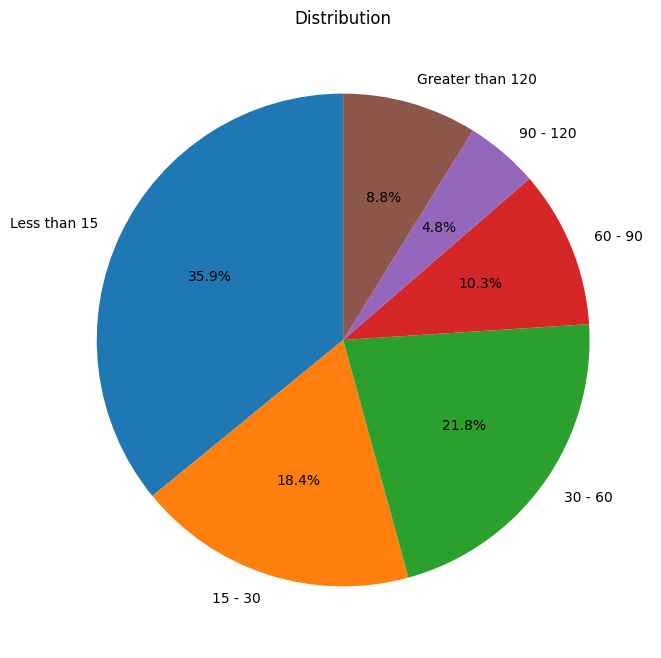

In [61]:
pie_last_6_months_average = last_6_months_average.iloc[:, 1:].iloc[0]
labels = pie_last_6_months_average.index
plt.figure(figsize=(8, 8))
plt.pie(pie_last_6_months_average, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution')
plt.show()

In [62]:
final_ratio

No of Days since Last Transaction,Order_Counts,Less than 15,15 - 30,30 - 60,60 - 90,90 - 120,Greater than 120
OrderMonth,,,,,,,
2023-01,759.0,0.13,0.13,0.20,0.16,0.10,0.27
2023-02,531.0,0.10,0.12,0.23,0.17,0.05,0.31
2023-03,578.0,0.15,0.17,0.28,0.13,0.08,0.18
2023-04,799.0,0.14,0.16,0.25,0.21,0.10,0.14
2023-05,727.0,0.15,0.13,0.29,0.17,0.11,0.16
2023-06,678.0,0.12,0.13,0.31,0.20,0.09,0.16
2023-07,770.0,0.18,0.17,0.27,0.18,0.13,0.08
2023-08,662.0,0.24,0.18,0.29,0.19,0.08,0.02
2023-09,837.0,0.37,0.17,0.31,0.13,0.00,0.01


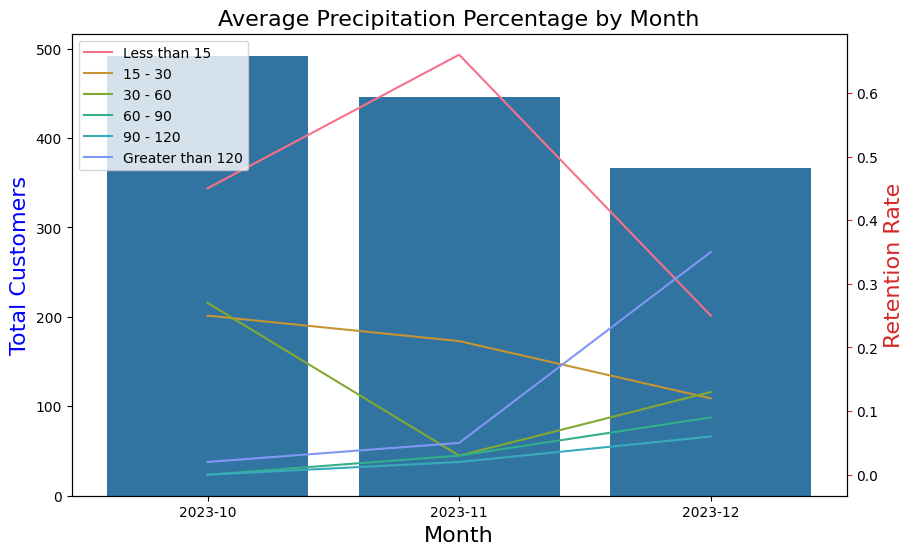

In [63]:
fig, ax1 = plt.subplots(figsize=(10, 6))
color1 = 'blue'
ax1.set_title('Average Precipitation Percentage by Month', fontsize=16)
ax1.set_xlabel('Month', fontsize=16)
ax1.set_ylabel('Total Customers', fontsize=16, color=color1)
ax2 = sns.barplot(x='OrderMonth', y='Order_Counts', data=final_ratio.tail(3))
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Retention Rate', fontsize=16, color=color2)

# Set custom colors for each line
color_palette = sns.color_palette("husl", 7)

sns.lineplot(x='OrderMonth', y="Less than 15", data=final_ratio.tail(3), sort=False, color=color_palette[0], label='Less than 15')
sns.lineplot(x='OrderMonth', y="15 - 30", data=final_ratio.tail(3), sort=False, color=color_palette[1], label='15 - 30')
sns.lineplot(x='OrderMonth', y="30 - 60", data=final_ratio.tail(3), sort=False, color=color_palette[2], label='30 - 60')
sns.lineplot(x='OrderMonth', y="60 - 90", data=final_ratio.tail(3), sort=False, color=color_palette[3], label='60 - 90')
sns.lineplot(x='OrderMonth', y="90 - 120", data=final_ratio.tail(3), sort=False, color=color_palette[4], label='90 - 120')
sns.lineplot(x='OrderMonth', y="Greater than 120", data=final_ratio.tail(3), sort=False, color=color_palette[5], label='Greater than 120')

ax2.tick_params(axis='y', color=color2)

# Add legend
ax2.legend(loc='upper left')

plt.show()

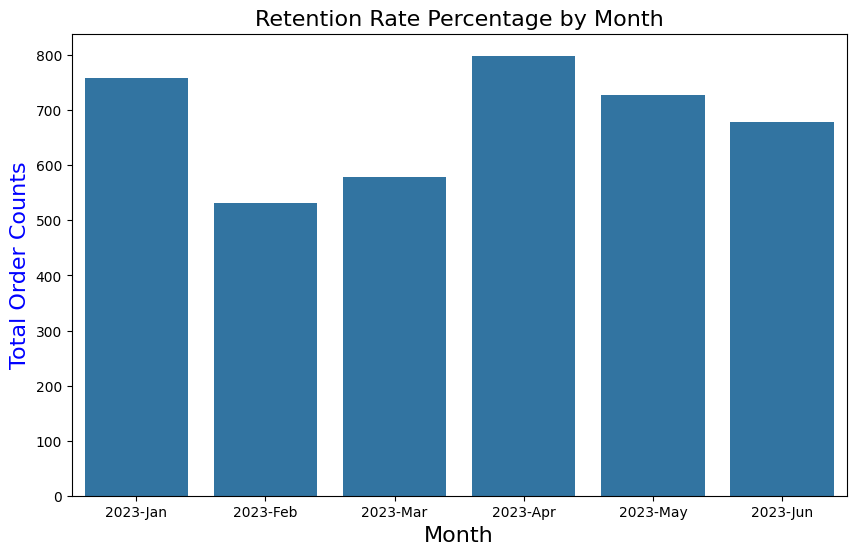

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(10, 6))
color1 = 'blue'
ax1.set_title('Retention Rate Percentage by Month', fontsize=16)
ax1.set_xlabel('Month', fontsize=16)
ax1.set_ylabel('Total Order Counts', fontsize=16, color=color1)
ax2 = sns.barplot(x='OrderMonth', y='Order_Counts', data=row_month)
ax1.tick_params(axis='y')

# ax2 = ax1.twinx()
# color2 = 'tab:red'
# ax2.set_ylabel('Retention Rate', fontsize=16, color=color2)

# sns.lineplot(x='OrderMonth', y="Less than 15", data=row_month, sort=False, color='black', label='Less than 15')
# sns.lineplot(x='OrderMonth', y="15 - 30", data=row_month, sort=False, color='blue', label='15 - 30')
# sns.lineplot(x='OrderMonth', y="30 - 60", data=row_month, sort=False, color='red', label='30 - 60')
# sns.lineplot(x='OrderMonth', y="60 - 90", data=row_month, sort=False, color='purple', label='60 - 90')
# sns.lineplot(x='OrderMonth', y="90 - 120", data=row_month, sort=False, color='orange', label='90 - 120')
# sns.lineplot(x='OrderMonth', y="Greater than 120", data=row_month, sort=False, color='cyan', label='Greater than 120')
# ax2.tick_params(axis='y', color=color2)
# ax2.legend(loc='upper left')
plt.show()

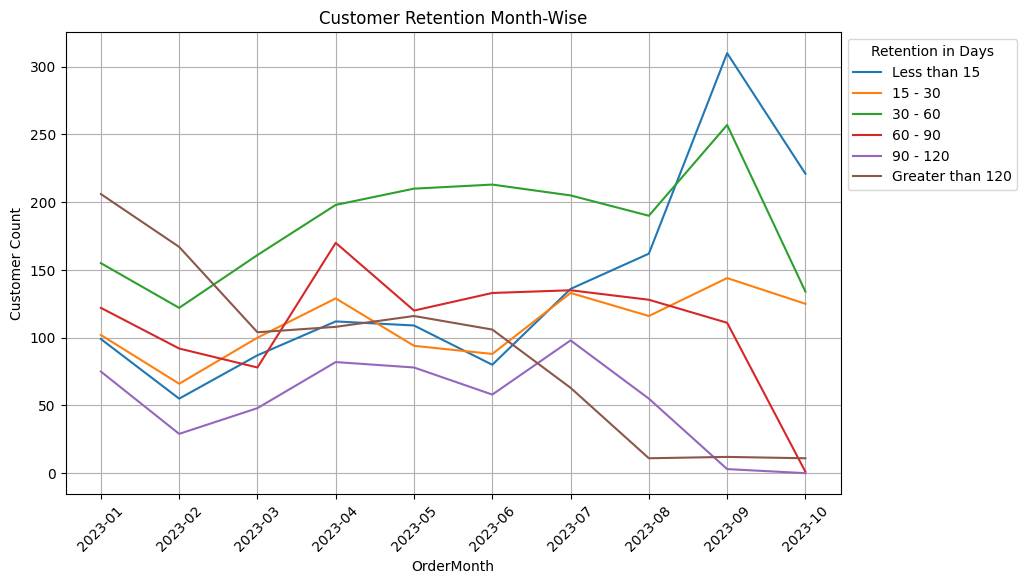

In [65]:
graph = final.drop(columns = ["Order_Counts"])
graph = graph.tail(12)[:-2]


plt.figure(figsize=(10, 6))
for column in graph.columns:
    plt.plot(graph.index, graph[column], label=column)

plt.title('Customer Retention Month-Wise')
plt.xlabel('OrderMonth')
plt.ylabel('Customer Count')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Retention in Days')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

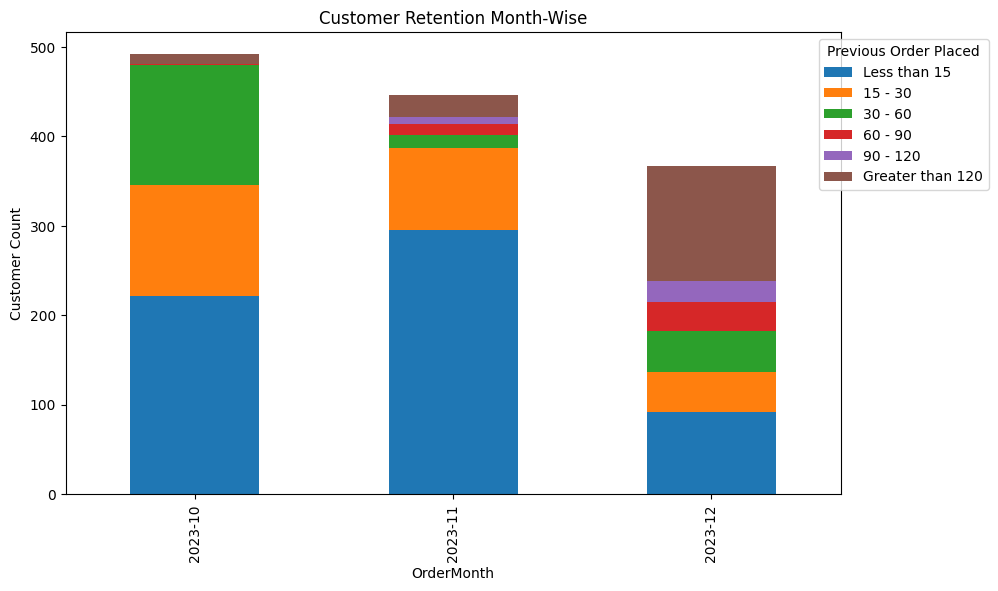

In [66]:
graph2 = final.drop(columns = ["Order_Counts"])
graph2 = graph2.tail(3)#[:-2]
graph2.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Customer Retention Month-Wise')
plt.xlabel('OrderMonth')
plt.ylabel('Customer Count')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), title = 'Previous Order Placed')
plt.show()

In [67]:
# Commented Lines

q=('''SELECT x.* FROM public.sales_userorderdata x
ORDER BY x.id,x.user_id 
''')

e=pd.read_sql(q,conn)
print(e.head())

#Diamentions Users, AverageOrderValue, OrderFrequency, Average Delta days in orders, Average Order Value Detla,User Maturity, Rececncy 

# Set Data Columns
e['OderDate']=e['created'].dt.date
e['OderDate']=pd.to_datetime(e['OderDate'])
#Delta Columns
e['DeltaDaysinOrders']=(e.groupby('user_id').OderDate.shift() - e.OderDate).dt.days.abs()
e['DeltaOrderValues']=(e.groupby('user_id').order_amount.shift() - e.order_amount)
#Analysis Parameters 
e=e[e['OderDate']>='2023-01-01']
e=e[e['OderDate']<= '2023-06-30']
e=e[e['order_status']=='Delivered']

x1=e.groupby('user_id').agg(
        LastDate=pd.NamedAgg(column='OderDate', aggfunc= 'max'),
        FirstDate=pd.NamedAgg(column='OderDate', aggfunc='min'),
        Frequency=pd.NamedAgg(column='order_id', aggfunc='nunique'),
        AOV=pd.NamedAgg(column='order_amount', aggfunc='mean'),
        MeanDaysDelta=pd.NamedAgg(column='DeltaDaysinOrders', aggfunc='mean'),
        MeanOVDelta=pd.NamedAgg(column='DeltaOrderValues', aggfunc='mean')

    ).reset_index()


globalmaxdate=e['OderDate'].max()
x1['Recency']=globalmaxdate-x1['LastDate']
x1['Recency']=x1['Recency'].dt.days.abs()
x1['ActivatedQuater']=x1['FirstDate'].dt.to_period('Q')
x1['MaturityAge']=x1['LastDate']-x1['FirstDate']
x1['MaturityAge']=x1['MaturityAge'].dt.days.abs()
x1['MeanDaysDelta']=x1['MeanDaysDelta'].fillna(0)
x1['MeanOVDelta']=x1['MeanOVDelta'].fillna(0)
x1['FrequencyperDeltaDays']=x1['Frequency']/x1['MeanDaysDelta']


r_labels, f2d_labels,AOV_labels, m_labels,DelAOV_labels = range(4, 0, -1), range(1,5), range(1,5),range(1,5),range(1,5)
x1['r_score'] = x1['Recency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = r_labels)).astype('int64')
x1['f2d_score'] = x1['FrequencyperDeltaDays'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = f2d_labels)).astype('int64')
x1['AOV_score'] = x1['AOV'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = AOV_labels)).astype('int64')
x1['m_score'] = x1['MaturityAge'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = m_labels)).astype('int64')
x1['DelAOV'] = x1['MeanOVDelta'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = DelAOV_labels)).astype('int64')
x1['SumScore'] = x1['r_score'] + x1['f2d_score'] + x1['m_score'] + x1['AOV_score']+ x1['DelAOV']

def CohortLables(df):
    if df['SumScore'] >= 18:
        return 'Champions'
    elif ((df['m_score'] <=1) and (df['SumScore'] >= 10)and (df['SumScore'] < 18) and (df['r_score'] >1)):
        return 'New & Potential'
    elif ((df['m_score'] >1) and (df['SumScore'] >= 14)and (df['SumScore'] < 18)and (df['r_score'] >1)):
        return 'Mature & Loyal'
    elif ((df['m_score'] >1) and (df['SumScore'] >= 10)and (df['SumScore'] < 14)and (df['r_score'] >1)):
        return 'Mature & Slow'
    
    elif ((df['m_score'] <=1) and (df['SumScore'] >= 5)and (df['SumScore'] < 10)and (df['r_score'] >1)):
        return 'New & Slow'
    elif ((df['m_score'] >1) and (df['SumScore'] >= 5)and (df['SumScore'] < 10)and (df['r_score'] >1)):
        return 'Mature & ChurnRisk'
    else:
        return 'Churned'
# Create a new variable RFM_Level
x1['CohortLabel'] = x1.apply(CohortLables, axis=1)

segstats=x1.groupby(
'CohortLabel'
).agg(
    Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),   
    Recency=pd.NamedAgg(column='Recency', aggfunc='mean'), 
    Frequency=pd.NamedAgg(column='Frequency', aggfunc='mean'),
    AOV=pd.NamedAgg(column='AOV', aggfunc='mean'),
    MeanDaysDelta=pd.NamedAgg(column='MeanDaysDelta', aggfunc='mean'),
    MeanOVDelta=pd.NamedAgg(column='MeanOVDelta', aggfunc='mean'),
    FrequencyperDeltaDays=pd.NamedAgg(column='FrequencyperDeltaDays', aggfunc='mean'),
    Maturity=pd.NamedAgg(column='MaturityAge', aggfunc='mean'),
    OrderCount=pd.NamedAgg(column='Frequency', aggfunc='sum'),
    
).reset_index()

segstats['OrderCountMix']=segstats['OrderCount']*100/segstats['OrderCount'].sum()
segstats['UsersMix']=segstats['Users']*100/segstats['Users'].sum()

# print(segstats.columns.tolist())
# save to csv
segstats.to_csv('segstats.csv')

# read from csv
# segstats = pd.read_csv('segstats.csv')


# create a copy of the dataframe
segstats_copy = segstats.copy()

# change the column name
segstats_copy.rename(columns={'CohortLabel':'User Type'}, inplace=True)
segstats_copy.rename(columns={'Users':'User Count'}, inplace=True)
segstats_copy.rename(columns={'Frequency':'Average Order Count'}, inplace=True)
segstats_copy.rename(columns={'AOV':'Average Order Value'}, inplace=True)
segstats_copy.rename(columns={'OrderCount':'Total Order Count Over Time'}, inplace=True)
segstats_copy.rename(columns={'MeanOVDelta':'Average Order Value Difference in Rs'}, inplace=True)
# segstats_copy.rename(columns={'FrequencyperDeltaDays':'Average Gap Between Orders in Days'}, inplace=True)
#  drop a column from the dataframe
segstats_copy.drop(columns=['FrequencyperDeltaDays'], inplace=True)
segstats_copy.rename(columns={'Maturity':'Average Maturity in Days'}, inplace=True)
segstats_copy.rename(columns={'OrderCountMix':'% Order Out Of Total Orders'}, inplace=True)
segstats_copy.rename(columns={'UsersMix':'% Users Out Of Total Users'}, inplace=True)
segstats_copy.rename(columns={'MeanDaysDelta':'Average Gap Between Orders in Days'}, inplace=True)
segstats_copy = segstats_copy.round(0)

# # segstats_copy.to_csv('cohort_'+start_date +'_to_' + end_date +'.csv')
segstats_copy["% Order Out Of Total Orders"] = segstats_copy["% Order Out Of Total Orders"].astype(str) + '%'
segstats_copy["% Users Out Of Total Users"] = segstats_copy["% Users Out Of Total Users"].astype(str) + '%'



C:\Users\CEPL\AppData\Local\Temp\ipykernel_13596\88662665.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  e=pd.read_sql(q,conn)


DatabaseError: Execution failed on sql 'SELECT x.* FROM public.sales_userorderdata x
ORDER BY x.id,x.user_id 
': relation "public.sales_userorderdata" does not exist
LINE 1: SELECT x.* FROM public.sales_userorderdata x
                        ^
